## Analysing model training

In [166]:
import util
from importlib import reload
reload(util)

<module 'util' from '/Users/luis/Desktop/Cranmer 2024/Workplace/smallMutations/similar-expressions/src/model/util.py'>

In [167]:
import torch
import os
import h5py
import sympy as sp
from util import data2input, prods_to_eq, plot_onehot, load_raw_parsed_data
from grammar import GCFG

datapath = '/Users/luis/Desktop/Cranmer 2024/Workplace/smallMutations/similar-expressions/data'
eqs, onehot = load_raw_parsed_data(datapath=datapath, name='expr_240807_5')

model_path = os.path.abspath('/Users/luis/Desktop/Cranmer 2024/Workplace/smallMutations/similar-expressions/smallMutations/similar-expressions/checkpoints/model_240807_1_5epoch.pt')
vae_model = torch.load(model_path)

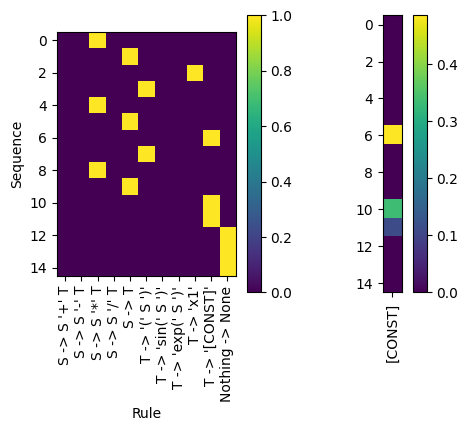

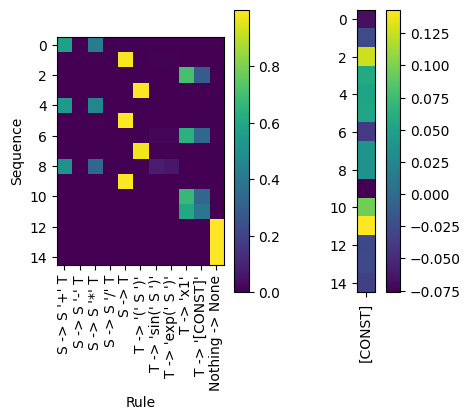

In [168]:
i = 1000
x = data2input(onehot[i, ...])
mu, sigma = vae_model.encoder(x)

z = vae_model.sample(mu, sigma)

logits = vae_model.decoder(z, max_length=15)

plot_onehot(x.squeeze(0).T.detach().numpy(), GCFG, figsize=(5, 4))
plot_onehot(logits.squeeze(0).detach().numpy(), GCFG, apply_softmax=True, figsize=(5, 4))

In [129]:
mu, sigma

(tensor([[ 0.1684, -1.4036]], grad_fn=<AddmmBackward0>),
 tensor([[5.7642e-16, 8.1407e-15]], grad_fn=<SoftplusBackward0>))

In [155]:
z = vae_model.sample(mu, sigma*1e7)
prods = vae_model.generate(z, sample=False, max_length=15)
expr_str = prods_to_eq(prods, verbose=True)
print(f'{expr_str}; Original:\n{eqs[i]}')

x1 + ( x1 + ( x1 + x1 ) ); Original:
((x1*(-0.2935903072357178))+x1)+(-0.7014608383178711)


In [297]:
from util import load_onehot_data, batch_iter

# Load data
parsed_path = r'/Users/luis/Desktop/Cranmer 2024/Workplace/smallMutations/similar-expressions/data/onehot_parsed.h5'
data = load_onehot_data(parsed_path)
data = torch.from_numpy(data).float()  # .to(model.device)

x, y_rule_idx, y_consts = next(batch_iter(data, 10))

# Turn x from onehot (i.e. probability) into logits
epsilon = 1e-1  # Small value to avoid log(0)
x[:, :-1, :] = torch.log(x[:, :-1, :].clamp(min=epsilon, max=1-epsilon)) - torch.log1p(-x[:, :-1, :].clamp(min=epsilon, max=1-epsilon))

In [132]:
i = 3
eq = eqs[i]

expr = sp.simplify(sp.sympify(eq))
print(f'{eq = }; {expr = }')

x = data2input(onehot[i, ...])
mu, sigma = vae_model.encoder(x)
production = vae_model.generate(mu, sample=True, max_length=15)

print(f'{production = }')
eq_hat = prods_to_eq(production, verbose=True)
if eq_hat:
    expr_hat = sp.simplify(sp.sympify(eq_hat))
    print(f'{expr_hat = }')

eq = '(x1 + -0.39264077005823406) * 0.6814422896206572'; expr = 0.6814422896206572*x1 - 0.267562025346901
production = [S -> S '*' T, S -> T, T -> '(' S ')', S -> S '-' T, S -> T, T -> '-7.4198079109191895', T -> 'x1', T -> 'x1']
expr_hat = -x1*(x1 + 7.4198079109191895)
